# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

git clone https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project

In [7]:
from IPython.display import Javascript
from nbconvert import HTMLExporter
from IPython.display import Javascript

def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import random_ops


In [2]:
# https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle

training_file = './data/train.p'
validation_file='./data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(34799, 32, 32, 3)
(34799,)
(4410, 32, 32, 3)
(4410,)
(12630, 32, 32, 3)
(12630,)


In [5]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

image_shape = X_train.shape[1:3]
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

lines = []
with open('signnames.csv', 'r') as f:
    lines = f.readlines()
lines = lines[1:] # remove SignName entry on the first line
class_names = [line.strip().split(',')[1] for line in lines]



Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

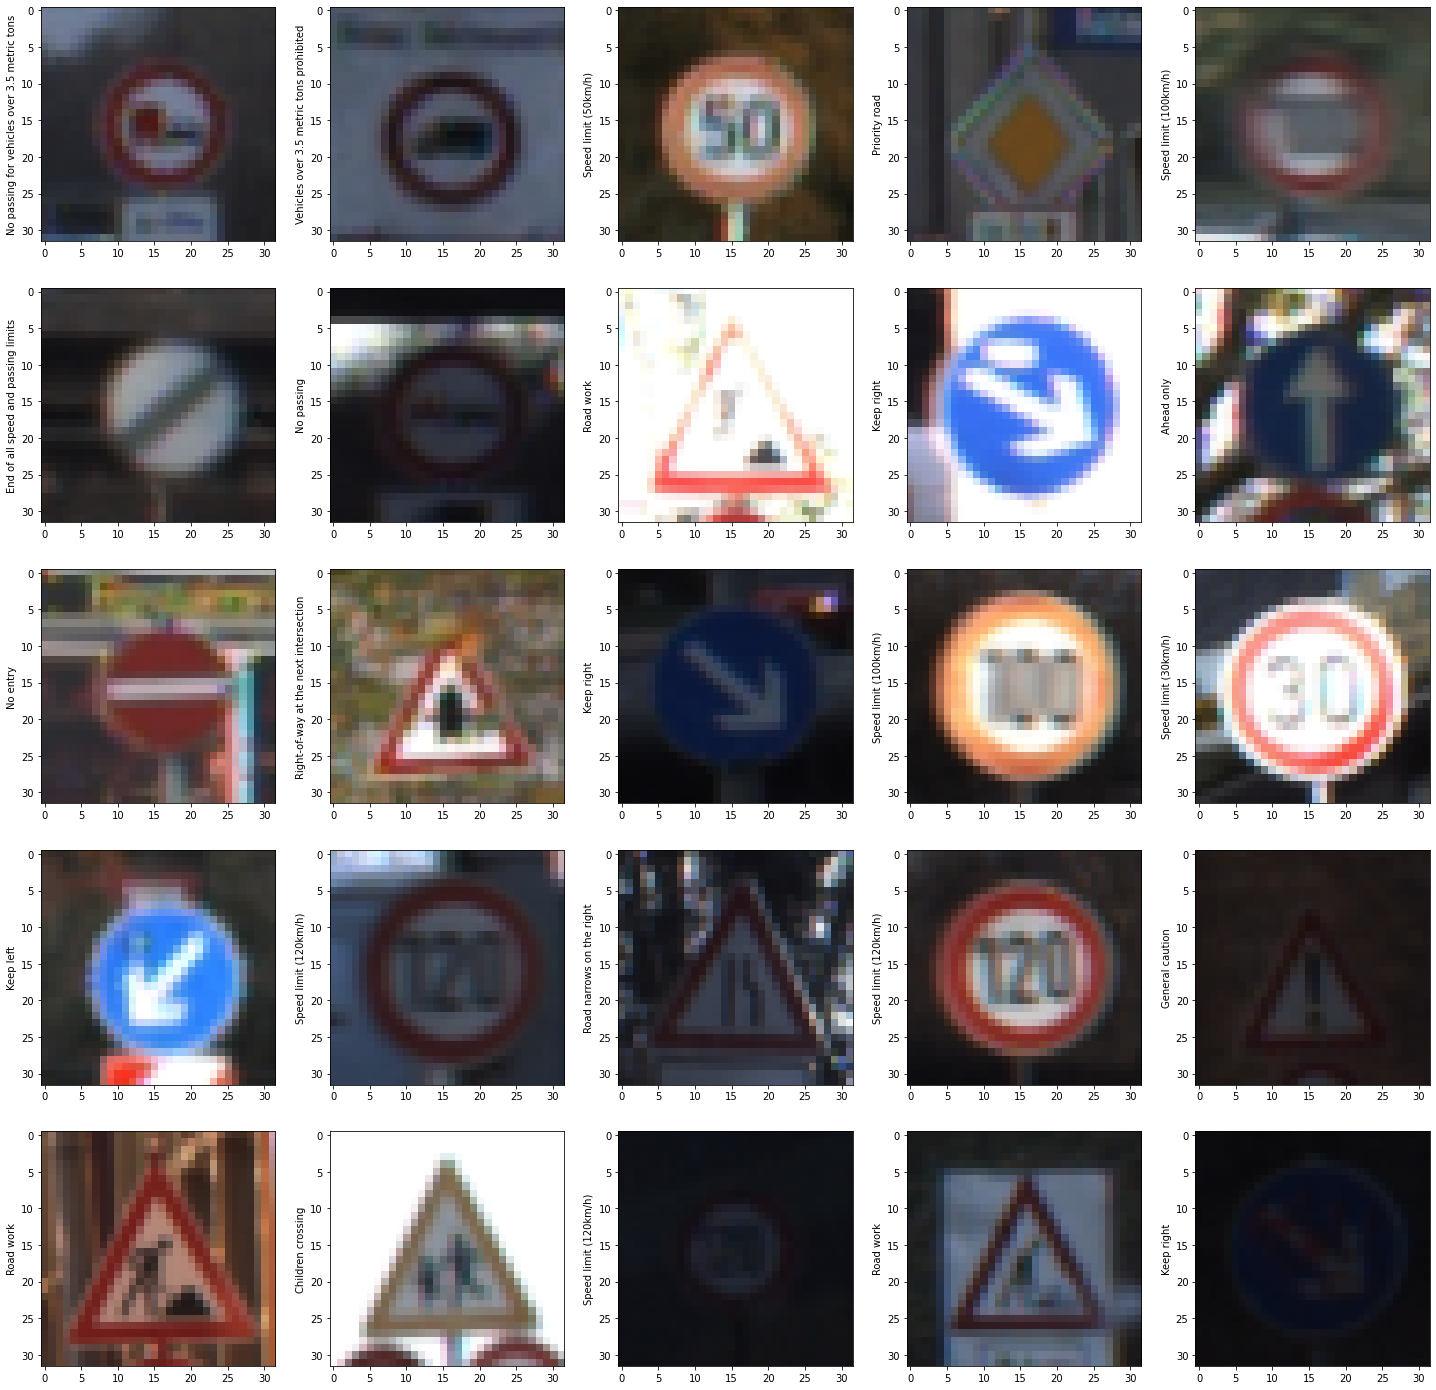

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nx = 5
ny = 5

indexes = np.random.randint(0, len(X_train), nx*ny)
fig = plt.figure(figsize=(25, 25))
for i in range(nx):
    for j in range(ny):
        index = i * ny + j
        plt.subplot(nx, ny, index + 1)
        image = X_train[indexes[index]].squeeze()
        plt.imshow(image)
        plt.ylabel(class_names[y_train[indexes[index]]])
fig.savefig('output_images/images.jpg')


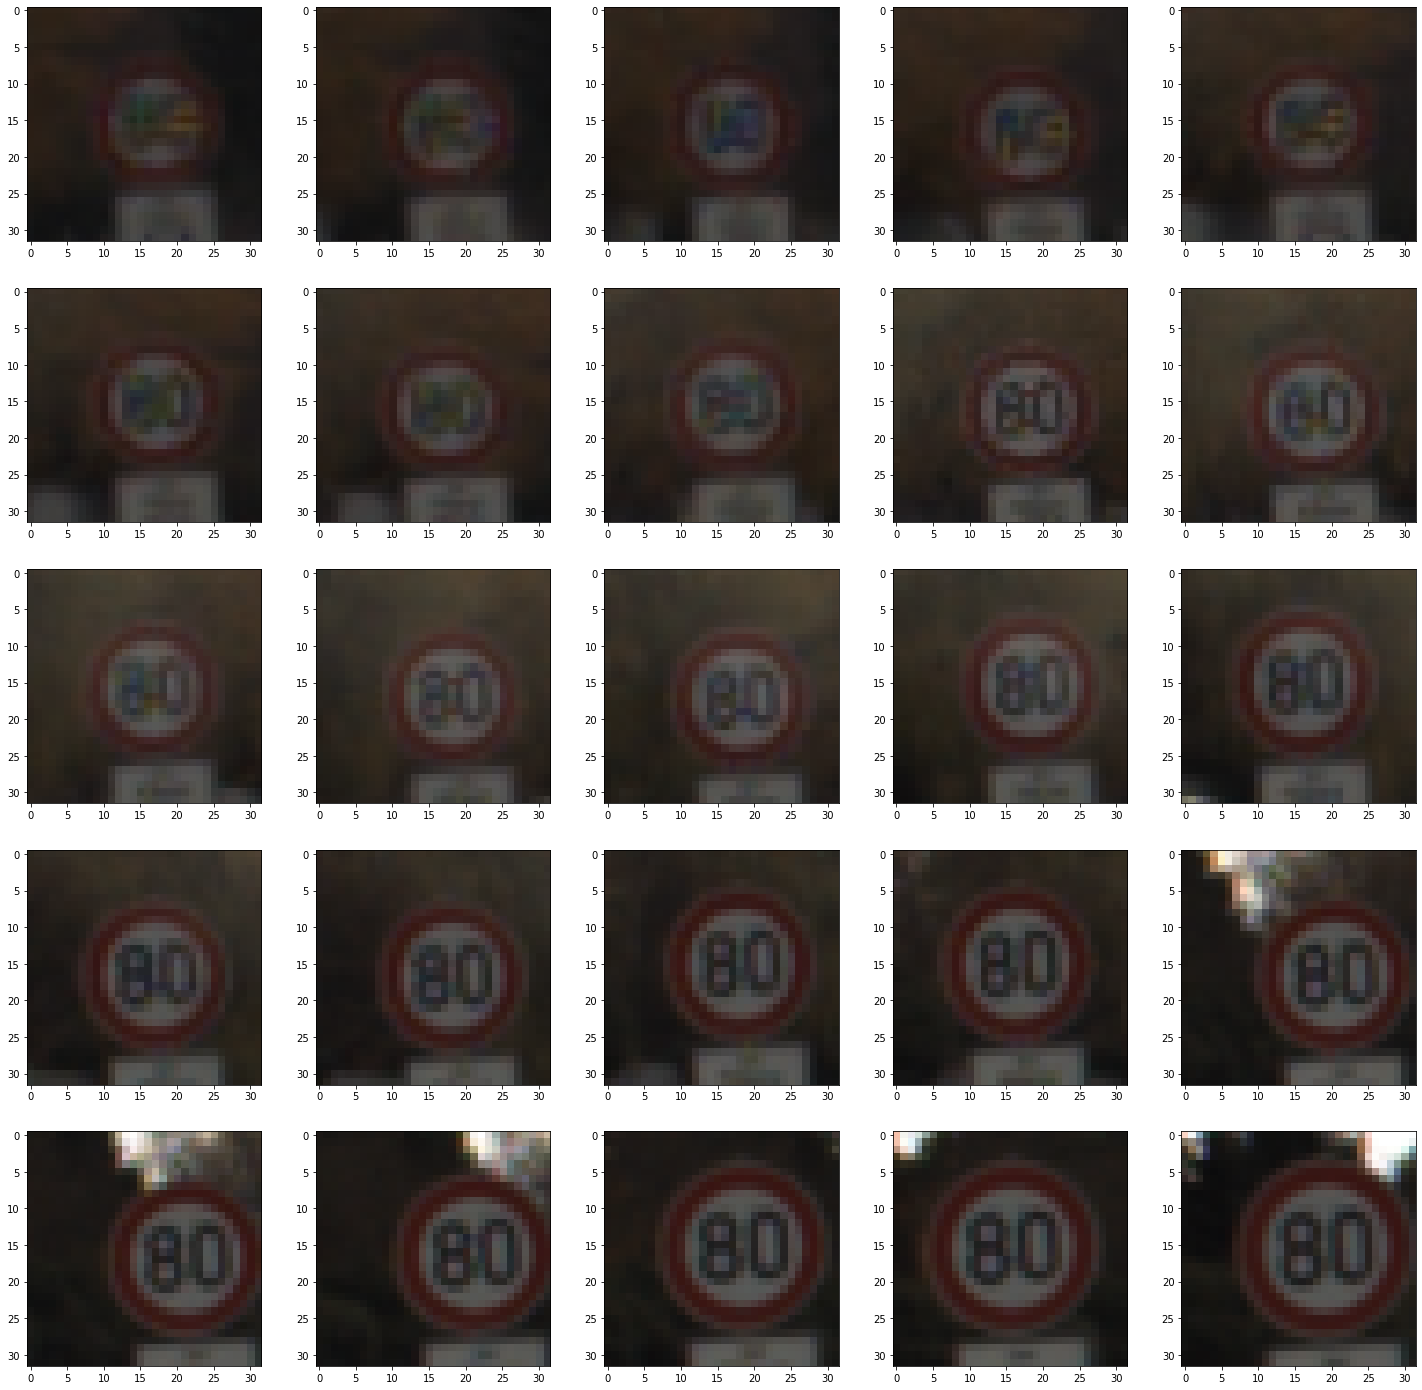

In [7]:
nx = 5
ny = 5

indexes = (y_train==5).nonzero()[0][:25]
fig = plt.figure(figsize=(25, 25))
for i in range(nx):
    for j in range(ny):
        index = i * ny + j
        plt.subplot(nx, ny, index + 1)
        image = X_train[indexes[index]].squeeze()
        plt.imshow(image)
fig.savefig('output_images/sample_80.jpg')

In [8]:
def plot_distro(y, ttl):
    dist = np.zeros((n_classes,), np.float)
    for i in range(n_classes):
        n_this_class = len((y==i).nonzero()[0])
        dist[i] = n_this_class / len(y_train)
    plt.bar(np.arange(0, n_classes, 1), dist)
    plt.title(ttl)
    plt.show()


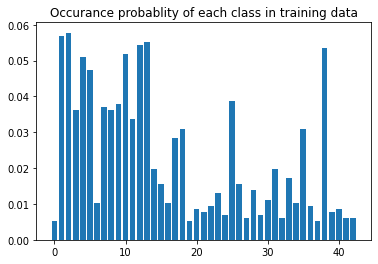

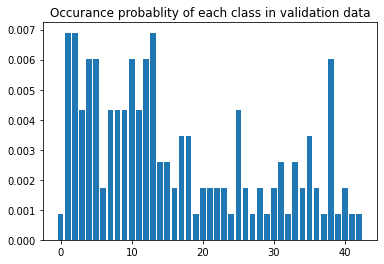

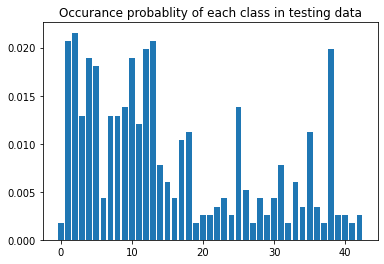

In [9]:
plot_distro(y_train, 'Occurance probablity of each class in training data')
plot_distro(y_valid, 'Occurance probablity of each class in validation data')
plot_distro(y_test, 'Occurance probablity of each class in testing data')


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import cv2


def addGray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    b, g, r = cv2.split(image)
    image = cv2.merge([b, g, r, gray])
    return image

(X_train, y_train) = shuffle(X_train, y_train)



# convert integers to float; normalise and center the mean
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test = X_test.astype("float32")

# X_train = (X_train - 128) / 128
# X_valid = (X_valid - 128) / 128
# X_test = (X_test - 128) / 128

# mean = np.mean(X_train)
# std = np.std(X_train)
# X_train = (X_train - mean) / std
# X_valid = (X_valid - mean)/ std
# X_test = (X_test - mean) / std

# X_train = np.array(list(map(addGray, X_train)))
# X_valid = np.array(list(map(addGray, X_valid)))
# X_test = np.array(list(map(addGray, X_test)))

X_train /= 255.
X_valid /= 255.
X_test /= 255.
# y_train = tf.one_hot(y_train, n_classes)
# y_valid = tf.one_hot(y_valid, n_classes)
# y_test = tf.one_hot(y_test, n_classes)

In [11]:
# from keras.preprocessing.image import ImageDataGenerator


# set up image augmentation
# datagen = ImageDataGenerator(rotation_range=10,
#                             shear_range=0.1,
#                             height_shift_range=0.1,
#                             width_shift_range=0.1,
#                             horizontal_flip=False,
#                             zoom_range=0.2)
# datagen.fit(X_train)

### Model Architecture

In [12]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input
from keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

def incept(x, n1, n3, n5):
    x3 = Conv2D(filters=n3, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x5 = Conv2D(filters=n5, kernel_size=(5, 5), activation='relu', padding='SAME')(x)
    x1 = Conv2D(filters=n1, kernel_size=(1, 1), activation='relu', padding='SAME')(x)
    return tf.concat([x3, x5, x1], axis=3)
    


In [13]:
def model_incept_fun(x):
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    x = incept(x, 16, 64, 32)
    x = MaxPooling2D()(x)

    x = incept(x, 8, 32, 16)
    x = Flatten()(x)
    x = Dense(units=400, activation='relu')(x)
    x = Dense(units=n_classes, activation='softmax')(x)
    return x

In [14]:
def model_lenet_fun(x):
    x = Conv2D(filters=6, kernel_size=(5, 5), activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(units=120, activation='relu')(x)
    x = Dense(units=84, activation='relu')(x)
    x = Dense(units=n_classes, activation='softmax')(x)
    return x

In [15]:
input_layer = Input((32, 32, 3))
x = input_layer
x = model_lenet_fun(x)
model_lenet = Model(input_layer, x, name='input_layer')
model_lenet.summary()

Model: "input_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               

In [16]:
input_layer = Input((32, 32, 3))
x = input_layer
x = model_incept_fun(x)
model_incept = Model(input_layer, x, name='input_layer')
model_incept.summary()

Model: "input_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 30, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_3[0][0]                   
________________________________________________________________________________________

### Train, Validate and Test the Model

In [17]:
model_lenet.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_lenet = model_lenet.fit(X_train, y_train, batch_size=64, epochs=50, shuffle=True, validation_data=(X_valid, y_valid), verbose=1)
# history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
#                             epochs=50,
#                             shuffle=True,
#                             validation_data=(X_valid, y_valid), verbose=1)

# for k in history.history.keys():
#     print(f'Training {k}= {str(history.history[k])}')


Epoch 1/50
544/544 [==============================] - 8s 6ms/step - loss: 2.4379 - accuracy: 0.3632 - val_loss: 0.8369 - val_accuracy: 0.7794
Epoch 2/50
544/544 [==============================] - 2s 3ms/step - loss: 0.4382 - accuracy: 0.8781 - val_loss: 0.5924 - val_accuracy: 0.8408
Epoch 3/50
544/544 [==============================] - 2s 3ms/step - loss: 0.2223 - accuracy: 0.9393 - val_loss: 0.5009 - val_accuracy: 0.8814
Epoch 4/50
544/544 [==============================] - 2s 4ms/step - loss: 0.1450 - accuracy: 0.9631 - val_loss: 0.4912 - val_accuracy: 0.8787
Epoch 5/50
544/544 [==============================] - 2s 4ms/step - loss: 0.0966 - accuracy: 0.9756 - val_loss: 0.4280 - val_accuracy: 0.9016
Epoch 6/50
544/544 [==============================] - 2s 3ms/step - loss: 0.0719 - accuracy: 0.9812 - val_loss: 0.5325 - val_accuracy: 0.8739
Epoch 7/50
544/544 [==============================] - 2s 3ms/step - loss: 0.0574 - accuracy: 0.9842 - val_loss: 0.4540 - val_accuracy: 0.9052
Epoch 

In [18]:
model_incept.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_incept = model_incept.fit(X_train, y_train, batch_size=64, epochs=50, shuffle=True, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/50
544/544 [==============================] - 5s 8ms/step - loss: 1.6870 - accuracy: 0.5338 - val_loss: 0.3298 - val_accuracy: 0.9073
Epoch 2/50
544/544 [==============================] - 4s 8ms/step - loss: 0.0683 - accuracy: 0.9823 - val_loss: 0.3662 - val_accuracy: 0.9302
Epoch 3/50
544/544 [==============================] - 4s 7ms/step - loss: 0.0314 - accuracy: 0.9910 - val_loss: 0.3529 - val_accuracy: 0.9286
Epoch 4/50
544/544 [==============================] - 4s 7ms/step - loss: 0.0127 - accuracy: 0.9966 - val_loss: 0.3423 - val_accuracy: 0.9370
Epoch 5/50
544/544 [==============================] - 4s 7ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.2951 - val_accuracy: 0.9485
Epoch 6/50
544/544 [==============================] - 4s 8ms/step - loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.3834 - val_accuracy: 0.9234
Epoch 7/50
544/544 [==============================] - 4s 8ms/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.2626 - val_accuracy: 0.9553
Epoch 

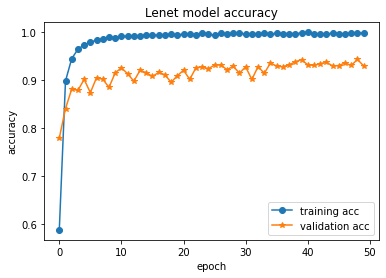

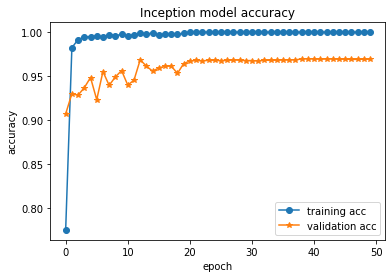

In [19]:

plt.plot(history_lenet.history['accuracy'], '-o')
plt.plot(history_lenet.history['val_accuracy'], '-*')
plt.legend(['training acc', 'validation acc'])
plt.title('Lenet model accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('output_images/lenet.jpg')
plt.show()

plt.plot(history_incept.history['accuracy'], '-o')
plt.plot(history_incept.history['val_accuracy'], '-*')
plt.legend(['training acc', 'validation acc'])
plt.title('Inception model accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('output_images/incept.jpg')
plt.show()

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [20]:
scores = model_lenet.evaluate(X_test, y_test)
print('------Lenet Evaluation------')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


scores = model_incept.evaluate(X_test, y_test)
print('------Inception Evaluation------')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


395/395 [==============================] - 1s 2ms/step - loss: 1.0514 - accuracy: 0.9183
------Lenet Evaluation------
Test loss: 1.0514240264892578
Test accuracy: 0.9182897806167603
395/395 [==============================] - 1s 3ms/step - loss: 0.4622 - accuracy: 0.9643
------Inception Evaluation------
Test loss: 0.4621712565422058
Test accuracy: 0.9642913937568665


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

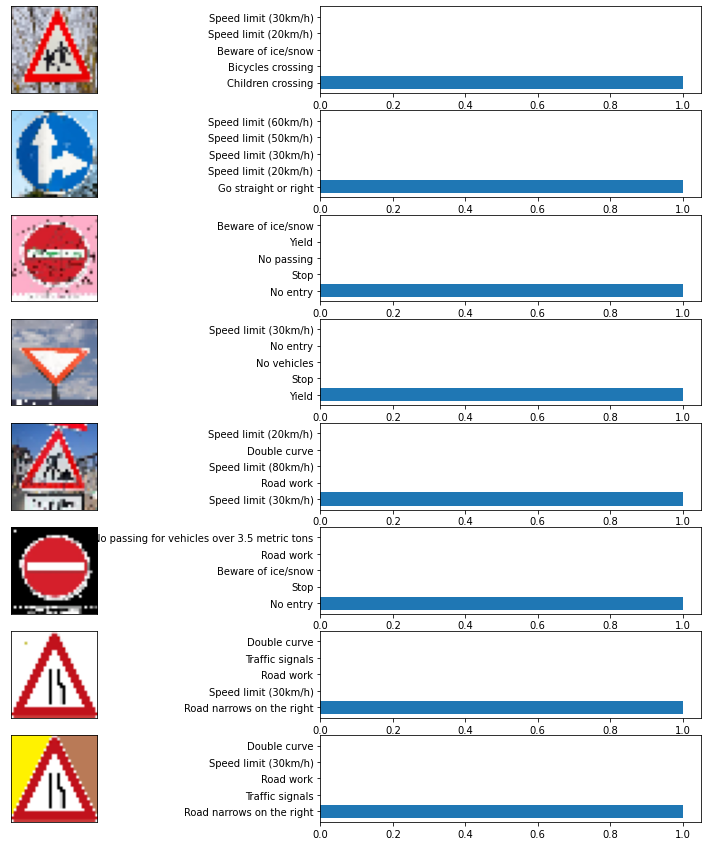

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
import cv2


n_image = 8
images = [0] * n_image
fig = plt.figure(figsize=(15, 15))
fig.tight_layout()

for i in range(n_image):
    images[i] = cv2.imread(f'examples/ex{str(i+1)}.jpg')
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    images[i] = cv2.resize(images[i], (32, 32))
    plt.subplot(n_image, 2, i*2+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
   
    x = np.array(images[i], dtype=np.float32).reshape((1, 32, 32, 3))
    x /= 255
    sm = model_incept.predict(x)
    
    top5 = tf.nn.top_k(sm, 5)
    top5_v = top5.values.numpy()[0]
    top5_i = top5.indices.numpy()[0]
    # plt.ylabel(lines[int(top5_i[0])])

    plt.subplot(n_image, 2, i*2+2)
    plt.barh(list(range(5)), top5_v)
    c = [class_names[i] for i in top5_i]
    plt.yticks(list(range(5)), c)

fig.savefig('output_images/new_images.jpg')


In [22]:
for i, c in enumerate(class_names):
    print(f'{i}: {c}')

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End of all speed and passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End of no passing by vehic